# This notebook constitutes ou project monitor

Imports and settings

In [17]:
%load_ext autoreload
%autoreload 2

import scripts.data_loader as data_loader
import scripts.data_processing as data_processing
import scripts.data_visualization as data_visualization

# Increase the number of columns displayed by pandas
import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importation of data

In [18]:
# Configuration
GOLD_SYMBOL = 'GC=F'
START_DATE = '2022-01-01'
END_DATE = '2024-10-01'

# Load or download data
gold_data = data_loader.get_gold_data(GOLD_SYMBOL, START_DATE, END_DATE, refresh=False)

# Check for missing values
data_processing.missing_values_checking(gold_data)

File found at: c:\Users\polol\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv. 
 Loading data...

Loading data from c:\Users\polol\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv...
Loaded DataFrame columns:
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
No missing values detected.


New features computation

In [19]:

# - **Log Price**: Logarithm of the "Close" price, providing a scaled and stabilized version of the closing price.
# - **Log Return**: Daily difference of Log Price, capturing daily price momentum in a log-scaled format.
# - **Moving Average (20 days)**: Rolling average of the "Close" price over 20 days, highlighting longer-term trends.
# - **Log Mid-Price**: Logarithm of the mid-price (average of "High" and "Low"), stabilizing variance and converting
#   multiplicative changes into additive ones for better analysis.
# - **Log Mid-Price Return**: Daily difference of Log Mid-Price, capturing log-scaled variations in mid-price.
# - **Spread**: Difference between "High" and "Low" prices, indicating price volatility within a time interval.
# - **Imbalance**: Relative volume difference between consecutive intervals, capturing market sentiment and activity.
# - **Volatility_x_days** Volatility for windows (number of daily values used to compute) 8, 15, 21, 50, 90, 120, 260
gold_data = data_processing.add_metrics(gold_data)


Visualisation of the data

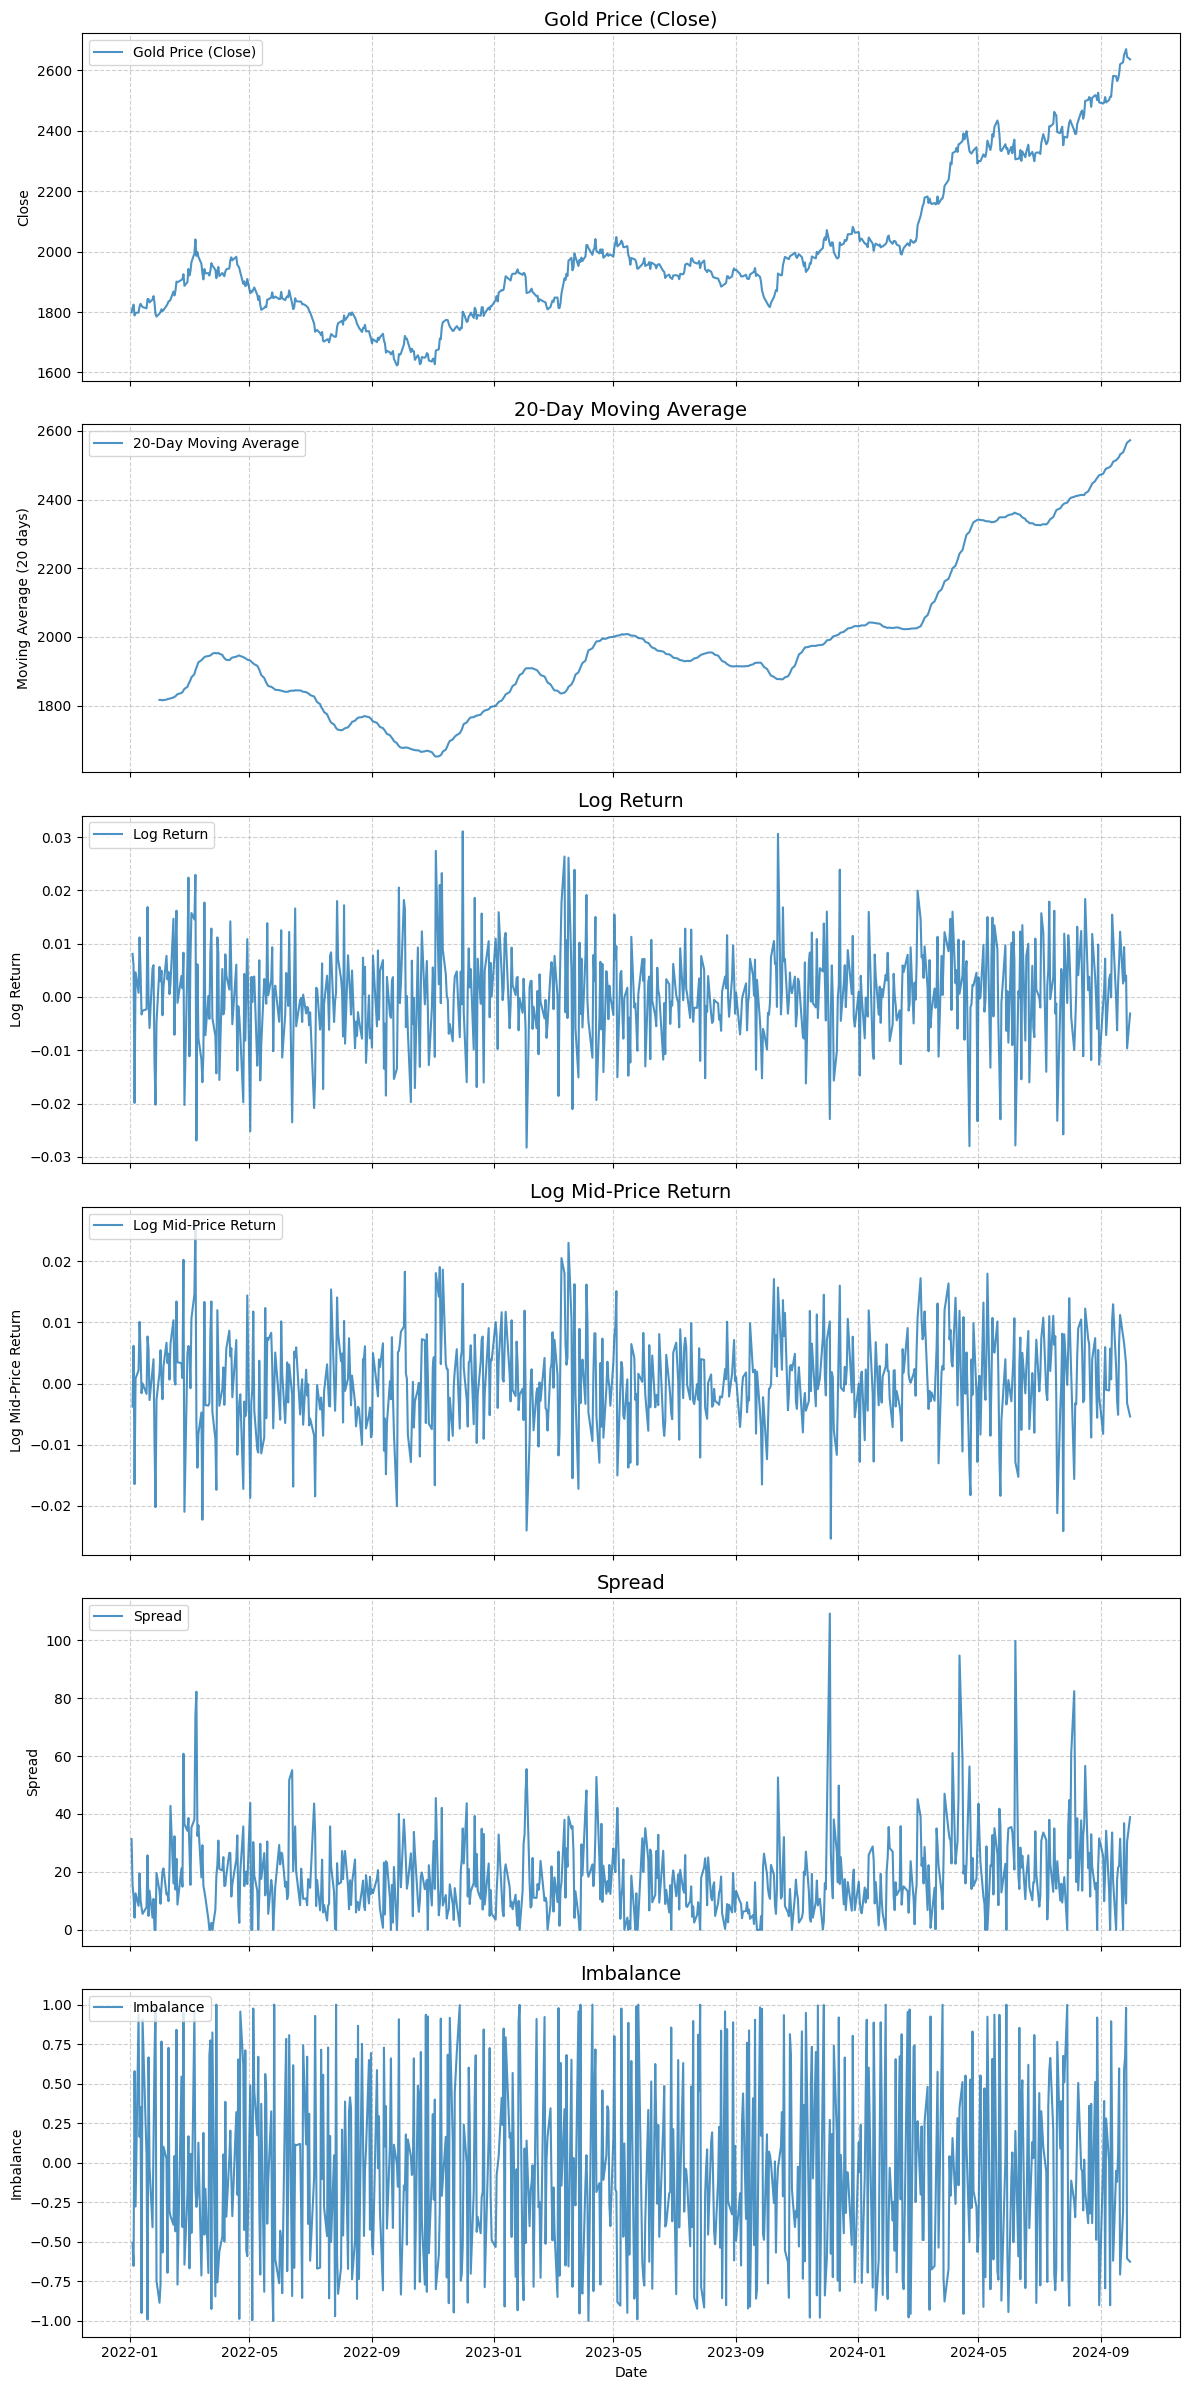

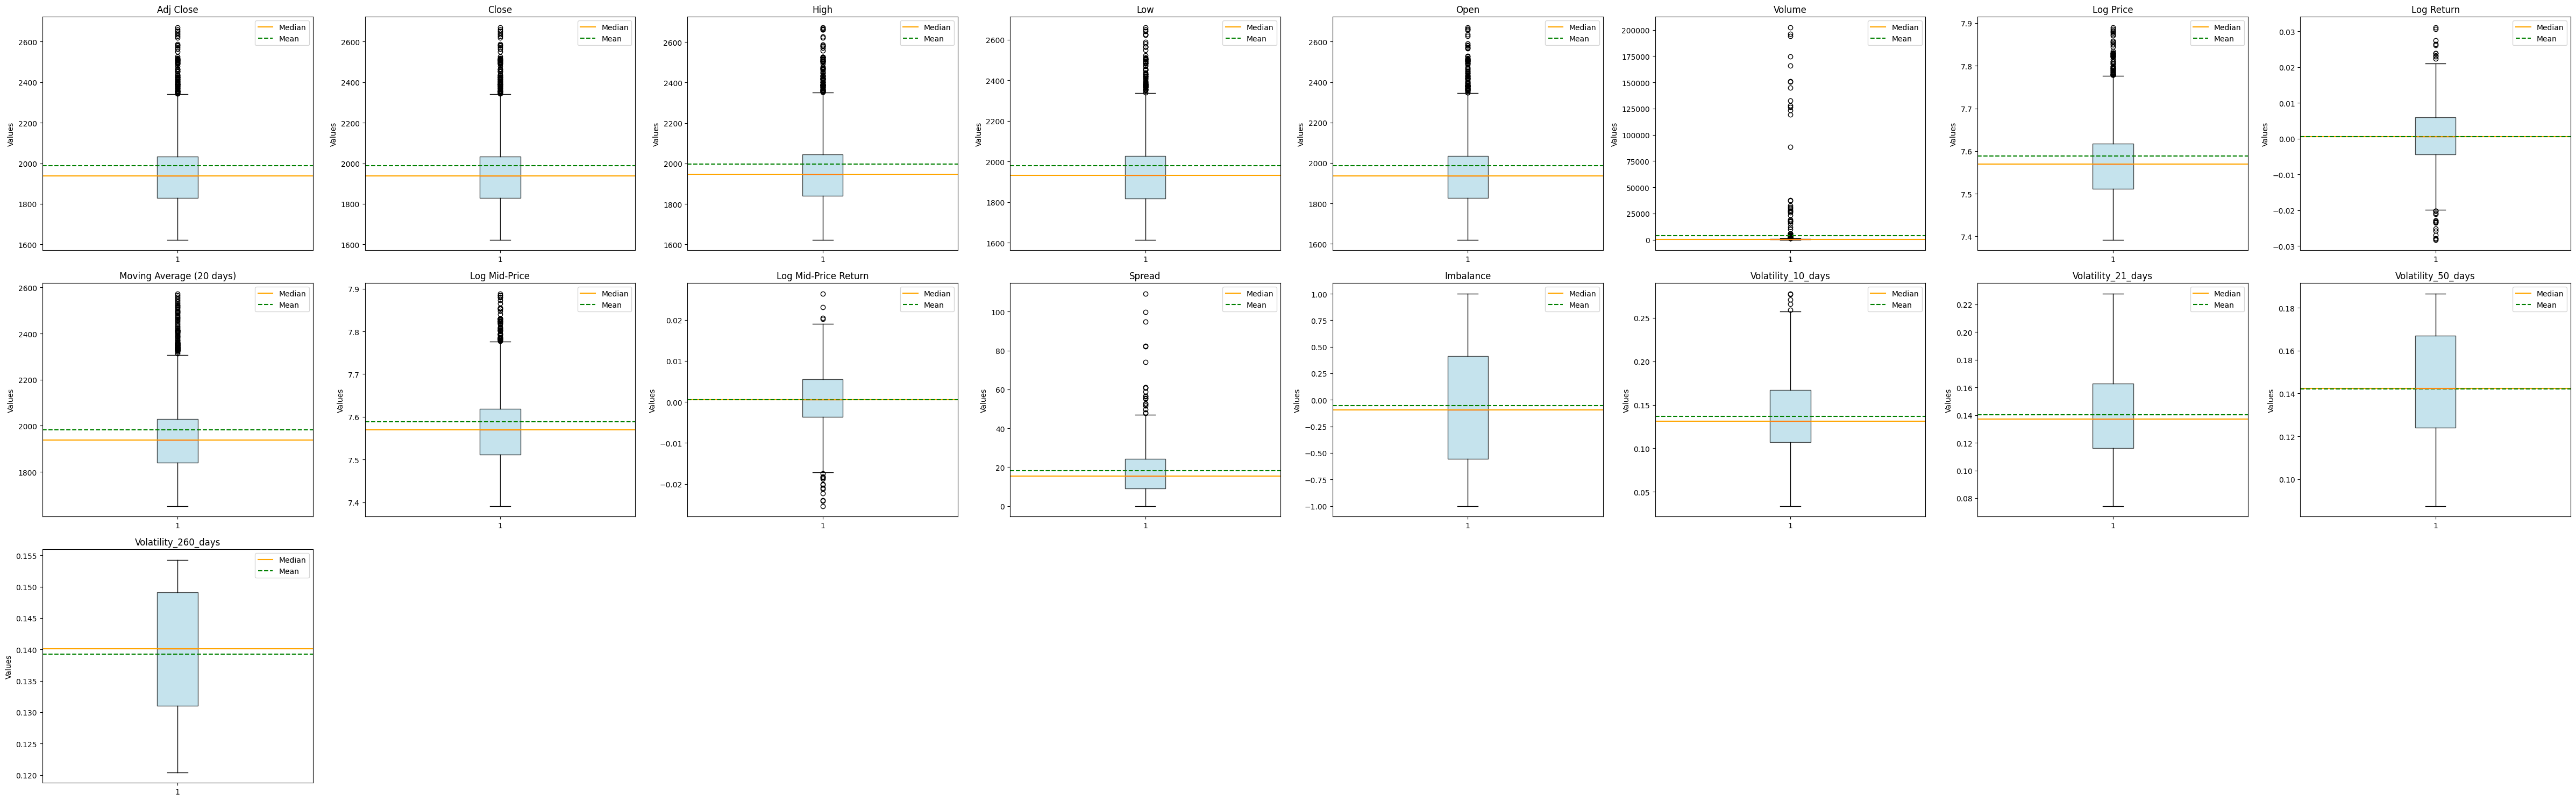

In [20]:
# Visualize all key metrics in a single multi-panel plot
data_visualization.plot_metrics(gold_data)

# Outliers identification
# Plot box plots for all numeric variables
data_visualization.plot_boxplots(gold_data, plots_per_column=8)


We keep only the main features we will use for model training

In [21]:
selected_data = gold_data[['Imbalance', 'Spread', 'Log Mid-Price Return', 'Moving Average (20 days)', 'Log Return', 'Volume', 'Close', 'Volatility_10_days', 'Volatility_21_days', 'Volatility_50_days','Volatility_260_days']]

display(selected_data)

,Imbalance,Spread,Log Mid-Price Return,Moving Average (20 days),Log Return,Volume,Close,Volatility_10_days,Volatility_21_days,Volatility_50_days,Volatility_260_days
Date,,,,,,,,,,,
2022-01-03,NaN,31.299927,NaN,NaN,NaN,116,1799.400024,NaN,NaN,NaN,NaN
2022-01-04,-0.506494,15.300049,-0.003755,NaN,0.008081,38,1814.000000,NaN,NaN,NaN,NaN
2022-01-05,-0.652174,11.500000,0.006177,NaN,0.005826,8,1824.599976,NaN,NaN,NaN,NaN
2022-01-06,0.578947,4.200073,-0.016436,NaN,-0.019872,30,1788.699951,NaN,NaN,NaN,NaN
2022-01-07,-0.276596,12.599976,0.000838,NaN,0.004630,17,1797.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,0.590909,36.800049,0.006603,2544.219983,0.009360,35,2651.199951,0.108579,0.112733,0.146230,0.142074
2024-09-25,0.666667,14.899902,0.004848,2551.379980,0.003013,175,2659.199951,0.105284,0.112676,0.142517,0.142064
2024-09-26,0.979875,9.099854,0.003232,2559.824976,0.004016,17216,2669.899902,0.090186,0.112126,0.142222,0.142088


Lead-lag computation

,Log Mid-Price_Lag,Log Mid-Price_Lead,Adj Close_Lead,Close_Lead,High_Lead,Low_Lead,Open_Lead,Volume_Lead,Log Price_Lead,Log Return_Lead,Moving Average (20 days)_Lead,Log Mid-Price Return_Lead,Spread_Lead,Imbalance_Lead,Volatility_10_days_Lead,Volatility_21_days_Lead,Volatility_50_days_Lead,Volatility_260_days_Lead
2022-01-03,7.503538,7.503538,1799.400024,1799.400024,1830.099976,1798.800049,1830.099976,116.0,7.495209,NaN,NaN,NaN,31.299927,NaN,NaN,NaN,NaN,NaN
2022-01-04,7.503538,7.499783,1814.000000,1814.000000,1815.300049,1800.000000,1800.500000,38.0,7.503290,0.008081,NaN,-0.003755,15.300049,-0.506494,NaN,NaN,NaN,NaN
2022-01-04,7.499783,7.499783,1814.000000,1814.000000,1815.300049,1800.000000,1800.500000,38.0,7.503290,0.008081,NaN,-0.003755,15.300049,-0.506494,NaN,NaN,NaN,NaN
2022-01-05,7.499783,7.505960,1824.599976,1824.599976,1824.599976,1813.099976,1813.099976,8.0,7.509116,0.005826,NaN,0.006177,11.500000,-0.652174,NaN,NaN,NaN,NaN
2022-01-05,7.505960,7.505960,1824.599976,1824.599976,1824.599976,1813.099976,1813.099976,8.0,7.509116,0.005826,NaN,0.006177,11.500000,-0.652174,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,7.888091,7.888091,2669.899902,2669.899902,2669.899902,2660.800049,2662.300049,17216.0,7.889796,0.004016,2559.824976,0.003232,9.099854,0.979875,0.090186,0.112126,0.142222,0.142088
2024-09-27,7.888091,7.884915,2644.300049,2644.300049,2672.100098,2641.699951,2670.000000,4228.0,7.880162,-0.009635,2565.754980,-0.003175,30.400146,-0.605671,0.105087,0.116378,0.144343,0.142375
2024-09-27,7.884915,7.884915,2644.300049,2644.300049,2672.100098,2641.699951,2670.000000,4228.0,7.880162,-0.009635,2565.754980,-0.003175,30.400146,-0.605671,0.105087,0.116378,0.144343,0.142375
2024-09-30,7.884915,7.879537,2636.100098,2636.100098,2662.100098,2623.199951,2660.899902,973.0,7.877056,-0.003106,2572.869983,-0.005378,38.900146,-0.625841,0.107986,0.114947,0.133247,0.142411


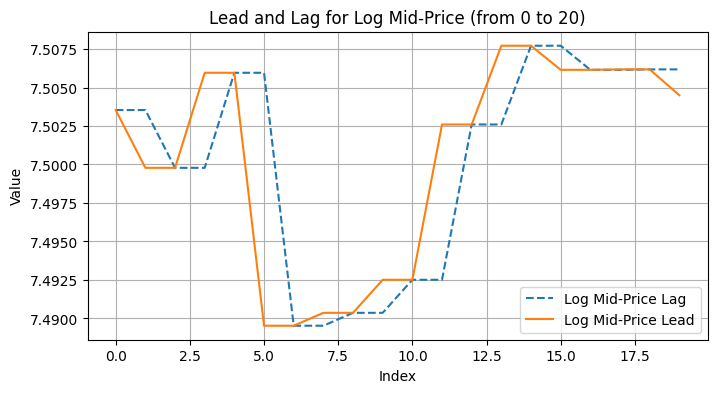

In [22]:
# Step 3: Apply lead-lag transformation
lead_lag_data = data_processing.apply_lead_lag(gold_data, lead_lag_columns=['Log Mid-Price'])

display(lead_lag_data)
# Visualize the transformed features lead-lag
data_visualization.plot_lead_lag(lead_lag_data, ["Log Mid-Price"])



Signatures computation

In [43]:
# Compute the signature of order 3 for the lead-lag data
signatures_order_2 = data_processing.compute_signature(
    selected_data,
    order=2,
    windows=[21],
    # exclude_cols = [] # Example: exclude the normalized time if present
)

# Print the resulting signature
print("Signature of order 2:")
print(signatures_order_2)
print(selected_data.dtypes)


<class 'list'>
['()', '(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)', '(8)', '(9)', '(10)', '(11)', '(1,1)', '(1,2)', '(1,3)', '(1,4)', '(1,5)', '(1,6)', '(1,7)', '(1,8)', '(1,9)', '(1,10)', '(1,11)', '(2,1)', '(2,2)', '(2,3)', '(2,4)', '(2,5)', '(2,6)', '(2,7)', '(2,8)', '(2,9)', '(2,10)', '(2,11)', '(3,1)', '(3,2)', '(3,3)', '(3,4)', '(3,5)', '(3,6)', '(3,7)', '(3,8)', '(3,9)', '(3,10)', '(3,11)', '(4,1)', '(4,2)', '(4,3)', '(4,4)', '(4,5)', '(4,6)', '(4,7)', '(4,8)', '(4,9)', '(4,10)', '(4,11)', '(5,1)', '(5,2)', '(5,3)', '(5,4)', '(5,5)', '(5,6)', '(5,7)', '(5,8)', '(5,9)', '(5,10)', '(5,11)', '(6,1)', '(6,2)', '(6,3)', '(6,4)', '(6,5)', '(6,6)', '(6,7)', '(6,8)', '(6,9)', '(6,10)', '(6,11)', '(7,1)', '(7,2)', '(7,3)', '(7,4)', '(7,5)', '(7,6)', '(7,7)', '(7,8)', '(7,9)', '(7,10)', '(7,11)', '(8,1)', '(8,2)', '(8,3)', '(8,4)', '(8,5)', '(8,6)', '(8,7)', '(8,8)', '(8,9)', '(8,10)', '(8,11)', '(9,1)', '(9,2)', '(9,3)', '(9,4)', '(9,5)', '(9,6)', '(9,7)', '(9,8)', '(9,9)', '(9,10)', 

Data formatting

In [16]:

# Step 4: Normalize the time column which can't be normalise as needed by transformers:
# time_normalized_data = data_processing.normalize_features(gold_data)

# We split the dataframe into  a train and a test set:



Columns in gold_data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log Price',
       'Log Return', 'Moving Average (20 days)', 'Log Mid-Price',
       'Log Mid-Price Return', 'Spread', 'Imbalance', 'Volatility_10_days',
       'Volatility_21_days', 'Volatility_50_days', 'Volatility_260_days'],
      dtype='object')
Columns in normalized_data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log Price',
       'Log Return', 'Moving Average (20 days)', 'Log Mid-Price',
       'Log Mid-Price Return', 'Spread', 'Imbalance', 'Volatility_10_days',
       'Volatility_21_days', 'Volatility_50_days', 'Volatility_260_days',
       'Normalized Time'],
      dtype='object')
